In [1]:
import base64
import boto3
import logging
import nest_asyncio
import operator
import os
import re
import time
import uuid

from botocore.config import Config
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from dotenv import load_dotenv
from IPython.display import display, HTML
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.llms.openai import OpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from langgraph.graph import END, StateGraph
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain_core.tools import StructuredTool
from typing import Annotated, Dict, List, Sequence, TypedDict, DefaultDict, Any, Optional
from typing_extensions import TypedDict

In [2]:
logger = logging.getLogger(__name__)

if not logger.hasHandlers():
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

### Loading of LLMs and Embedding Models
1. Llama Models
2. Normal Models
3. Embedding Models

In [3]:
load_dotenv()

CLAUDE_API_KEY = os.getenv('CLAUDE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

os.environ["ANTHROPIC_API_KEY"] = CLAUDE_API_KEY

In [4]:
openai_llama = OpenAI(model="gpt-3.5-turbo-0125", openai_api_key=OPENAI_API_KEY, temperature=0.0)
claude_llama = Anthropic(model="claude-3-5-sonnet-20240620", api_key=CLAUDE_API_KEY, temperature=0.0)

In [5]:
claude = ChatAnthropic(
    model="claude-3-5-sonnet-20240620",
    temperature=0.0,
    stop=["\n\nHuman"],
    streaming=True,
    stream_usage=True
)

In [6]:
# bge_embed_model = TextEmbedding(model_name="BAAI/bge-large-en-v1.5")
openai_embed_model = OpenAIEmbedding(model_name="text-embedding-3-small")

### Define GraphState's Storage Parameters

In [7]:
class GraphState(TypedDict):
    """
    Represents the state of a graph.

    Attributes:
        query (str): The user query
        expanded_queries (List[str]): The expanded queries generated by the agent
        agent (str): The agent responsible for decision making/answer generating
        contexts (DefaultDict[str, str]): The contexts retrieved. Keys are "kg" or "db" indicating the source of the context, and values are the contexts themselves
        answer (str): The answer generated by the agent
    """
    query: str
    expanded_queries: List[str]
    agent: str
    contexts: DefaultDict[str, str]
    answer: str

### Define Helper Functions
1. process_query_kg (retrieves context from KG according to query)
2. process_query_db (retrieves context from a traditional vector DB according to query)
3. get_kg_context (uses parallel processing to retrieve all contexts required from a query list, and formats it -- kg)
4. get_db_context (uses parallel processing to retrieve all contexts required from a query list, and formats it -- vector DB)

In [8]:
def process_query_kg(query: str, retriever) -> str:
    """
    Helper Function to retrieve context from KG a single query

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    return f"{retriever.get_context(query)}"

def process_query_db(query: str, retriever) -> str:
    """
    Helper Function to retrieve context from KG a single query

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    return f"{retriever.get_context(query)}"

In [9]:
def get_kg_context(queries: List[str], retriever) -> str:
    """
    Uses parallel processing to retrieve context from the KG for a list of queries.

    Args:
        query_list (List[str]): The list of user queries

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """

    context = []
        
    with ThreadPoolExecutor() as executor:
        future_to_query = {executor.submit(process_query_kg, query, retriever): query for query in queries}
        for future in as_completed(future_to_query):
            query = future_to_query[future]
            try:
                result = future.result()
                context.append(result)
            except Exception as exc:
                print(f"Query {query} generated an exception: {exc}")

    return "\n\n".join(context)

def get_db_context(queries: List[str], retriever) -> str:
    """
    Uses parallel processing to retrieve context from a Vector DB for a list of queries.

    Args:
        queries (List[str]): The list of user queries

    Returns:
        str: The formatted context retrieved from the DB
    """
    
    context = []
        
    with ThreadPoolExecutor() as executor:
        future_to_query = {executor.submit(process_query_db, query, retriever): query for query in queries}
        for future in as_completed(future_to_query):
            query = future_to_query[future]
            try:
                result = future.result()
                context.append(result)
            except Exception as exc:
                print(f"Query {query} generated an exception: {exc}")

    return "\n\n".join(context)

### Define Agents
1. Query Expansion Agent
2. Retrieval Agent
3. Grading Agent
4. Answer Generation

In [10]:
def query_expansion(query: str) -> List[str]:
    """
    Expands a query using LLM

    Args:
        query (str): The user query

    Returns:
        List[str]: The expanded queries
    """
    
    prompt = """<system>
    You are a creative AI assistant specializing in expanding user queries to make them more comprehensive and diverse. Your goal is to generate multiple variant queries based on the initial user query, capturing different aspects, synonyms, related terms, and broader or narrower contexts. Ensure that the expanded queries are relevant, diverse, and avoid repetition.
    </system>

    <instructions>
    1. Take the initial query provided by the user.
    2. Generate 3 variant queries that explore different interpretations, related topics, or alternative phrasings.
    3. Ensure the variants cover a range of specific to broad scopes and use synonyms or related terms.
    4. Avoid repeating the same information or using overly similar phrasing.
    5. Output the expanded queries in a JSON format, following the examples provided.
    6. Do not include any preamble, explanation, or additional information beyond the expanded queries in the given JSON format.
    </instructions>

    <example_output>
    Query: "machine learning algorithms"
    {{
        "expanded_queries": [
            "types of machine learning algorithms",
            "applications of supervised learning techniques",
            "deep learning vs traditional machine learning approaches"
        ]
    }}
    <example_output>

    <query>
    {query}
    </query>
    
    <response>
    [Your response here]
    </response>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    query_list = chain.invoke({"query": query})
    return query_list["expanded_queries"]

In [11]:
query_expansion_tool = StructuredTool.from_function(
    func=query_expansion,
    name="Query Expansion",
    description="Expands a query using LLM"
)

In [12]:
def query_expansion_agent(state: GraphState) -> GraphState:
    """
    Agent that expands the user query

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    expanded_queries = query_expansion_tool.invoke(state["query"])
    return {"expanded_queries": expanded_queries}

In [13]:
def retrieve_kg(queries: List[str]) -> str:
    """
    Retrieves context from the ingested knowledge graph, given a list of queries.
    Processes queries in parallel using ThreadPoolExecutor.

    Args:
        queries (List[str]): List of queries generated previously by the agent

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    
    kg_retriever = ...
    context = get_kg_context(queries=queries, retriever=kg_retriever)
    return context

In [14]:
retrieve_kg_tool = StructuredTool.from_function(
    func=retrieve_kg,
    name="Retrieve Knowledge Graph",
    description="Retrieves context from the ingested knowledge graph, given a list of queries"
)

In [15]:
def retrieve_kg_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from the ingested knowledge graph

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    context = retrieve_kg_tool.invoke(state["expanded_queries"] + [state["query"]])
    return {state["contexts"]["kg"]: context}

In [16]:
def retrieve_db(queries: List[str]) -> str:
    """
    Retrieves context from a conventional Vector DB, given a list of queries.

    Args:
        queries (List[str]): List of queries generated previously by the agent

    Returns:
        str: The formatted context retrieved from Vector DB
    """
    
    db_retriever = ...
    context = get_db_context(queries=queries, retriever=db_retriever)
    return context

In [17]:
retrieve_db_tool = StructuredTool.from_function(
    func=retrieve_db,
    name="Retrieve Vector DB",
    description="Retrieves context from a conventional Vector DB, given a list of queries."
)

In [18]:
def retrieve_conventional_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from a Vector DB

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    context = retrieve_db_tool.invoke(state["expanded_queries"] + [state["query"]])
    return {state["contexts"]["db"]: context}

In [19]:
def grader(query: str, context_kg: str, context_db: str) -> str:
    """
    Grades the contexts retrieved from KG and conventional sources based on relevance and quality to the query

    Args:
        query (str): The user query

    Returns:
        str: The preferred context based on the grading criteria
    """
    
    prompt = """<system>
    You are an evaluator who specializes in assessing the relevance, accuracy, and quality of retrieved contexts. Your task is to evaluate two contexts retrieved from different databases and determine which one is better based on predefined criteria.
    </system>
    
    <instructions>
    1. Contextual Relevance: Assess how well each context aligns with the given topic or query.
    2. Accuracy: Evaluate the factual correctness and reliability of the information provided in each context.
    3. Completeness: Determine whether each context provides a comprehensive answer or sufficient coverage of the topic.
    4. Clarity and Coherence: Review the clarity, logical flow, and coherence of the text in each context.
    </instructions>
    
    <task>
    - Given the following query and the two contexts, provide a detailed evaluation of each one, and assign a numerical score for each of the metrics: Contextual Relevance, Accuracy, Completeness, and Clarity and Coherence. Score each metric on a scale from 1 to 10, where 1 is the lowest and 10 is the highest. There need not be decimal values in the scores.
    - Conclude with a decision on which context is better, along with a brief explanation of the reasons for your choice based on the criteria above.
    - Return your evaluation and decision in the exact JSON format as provided.
    - Do not include any preamble, explanation, or additional information beyond the evaluation and decision in the given JSON format.
    </task>
    
    <query>
    {query}
    </query>
    
    <context_kg>
    {context_kg}
    </context_kg>
    
    <context_db>
    {context_db}
    </context_db>
    
    <output_format>
    {{
        "evaluation": {{
            "context_kg": {{
                "contextual_relevance": 10,
                "accuracy": 9,
                "completeness": 9,
                "clarity_and_coherence": 8
            }},
            "context_db": {{
                "contextual_relevance": 7,
                "accuracy": 8,
                "completeness": 7,
                "clarity_and_coherence": 7
            }},
            "decision": "context_kg",
            "explanation": "The context retrieved from the knowledge graph is more comprehensive, accurate, and coherent, providing a better understanding of the topic."
        }}
    }}
    </output_format>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "context_kg", "context_db"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    result = chain.invoke({"query": query, "context_kg": context_kg, "context_db": context_db})
    return result["evaluation"]["decision"]

In [20]:
grader_tool = StructuredTool.from_function(
    func=grader,
    name="Grader",
    description="Grades the contexts retrieved from KG and conventional sources based on relevance and quality to the query"
)

In [21]:
def grader_agent(state: GraphState) -> GraphState:
    """
    Agent that grades the contexts retrieved from KG and conventional sources

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    decision = grader_tool.invoke(state["contexts"])
    return {state["contexts"]["decision"]: decision}

In [22]:
def check_context(state: GraphState) -> GraphState:
    """
    Agent that initiates the check for which context is better 

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: Unchanged state of the graph
    """
    agent = state["agent"]
    return {"agent": agent}

In [23]:
def decide_context(state: GraphState) -> GraphState:
    """
    Agent that decides which context is better and updates the state of the graph

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    decision = state["contexts"]["decision"]
    if decision == "kg":
        return "kg"
    return "db"

In [24]:
def db_answer_generator(query: str, context: str) -> str:
    """
    Generates an answer to the user query from the Vector DB context

    Args:
        query (str): The user query
        context (str): The context retrieved from the Vector DB

    Returns:
        str: The answer generated by the agent
    """
    
    prompt = """<system>
    You are an AI assistant that specializes in generating answers based on the provided context. Your goal is to provide a concise and informative response to the user's query by extracting relevant information from the given context.
    </system>

    <instruction>
    1. Understand the Query: Carefully read and understand the user's query to identify the key information required.
    2. Extract Relevant Information: Identify the most relevant parts of the provided context that directly answer the user's query.
    3. Conciseness and Clarity: Generate a response that is clear, concise, and directly addresses the user's question without including unnecessary information.
    4. Completeness: Ensure the answer covers all aspects of the query as much as possible based on the provided context.
    5. Neutral and Informative Tone: Provide the answer in a neutral, professional tone, ensuring factual accuracy.
    6. Stay Direct and Focused: Provide a straightforward answer without any introductory remarks, elaborations, or additional comments that do not pertain to the query.
    </instruction>
    
    <query>
    {query}
    </query>

    <context>
    {context}
    </context>

    <response>
    [Your response here]
    </response>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "context"],
        template=prompt
    )
    
    chain = prompt_template | claude | StrOutputParser()
    response = chain.invoke({"query": query, "context": context})
    return response

In [25]:
def dummy(state: GraphState) -> GraphState:
    """
    Dummy agent that does nothing

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: Unchanged state of the graph
    """
    return state

In [33]:
builder = StateGraph(GraphState)

builder.add_node("query_expansion", query_expansion_agent)
builder.add_node("search_kg_db", retrieve_kg_agent)
builder.add_node("search_vector_db", retrieve_conventional_agent)
builder.add_node("grade_contexts", grader)
builder.add_node("check_context", check_context)
builder.add_node("db_answer_generator", db_answer_generator)

# dummy nodes for now
builder.add_node("display_subgraphs", dummy)
builder.add_node("subgraph_1", dummy)
builder.add_node("subgraph_2", dummy)
builder.add_node("kg_answer_generator", dummy)

builder.set_entry_point("query_expansion")

# retrieve both in parallel
builder.add_edge("query_expansion", "search_kg_db")
builder.add_edge("query_expansion", "search_vector_db")

builder.add_edge(["search_kg_db", "search_vector_db"], "grade_contexts")

builder.add_edge("grade_contexts", "check_context")

builder.add_conditional_edges(
    "check_context",
    decide_context,
    {
        "kg": "display_subgraphs",
        "db": "db_answer_generator"
    }
)

builder.add_edge("db_answer_generator", END)

# dummy edges for now
builder.add_edge("display_subgraphs", "subgraph_1")
builder.add_edge("display_subgraphs", "subgraph_2")
builder.add_edge(["subgraph_1", "subgraph_2"], "kg_answer_generator")
builder.add_edge("kg_answer_generator", END)

graph = builder.compile()


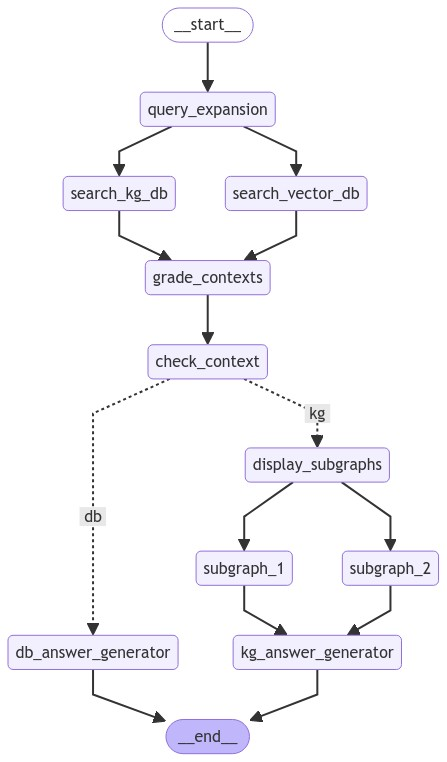

In [34]:
graph_png = graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    wrap_label_n_words=4,
    output_file_path=None,
    draw_method=MermaidDrawMethod.API,
    background_color="#000000",
    padding=10,
)

graph_base64 = base64.b64encode(graph_png).decode("utf-8")

HTML(f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{graph_base64}" width="400" height="auto"/>
</div>
''')